# Flower image classification
From tensorflow example


### Import Tensorflow keras numpy pandas and matplotlib

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging 
import os
import glob
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set logging level
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Load data from url

In [2]:
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 2s 0us/step


Dataset has 5 classes
* Rose
* Daisy
* Dandelion
* Sunflower
* Tulips

---
So lets create the labels for these classes


In [3]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

# Lets get the flower photos

In [4]:
for flower in classes:
  img_path = os.path.join(base_dir, flower)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(flower, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', flower)):
      os.makedirs(os.path.join(base_dir, 'train', flower))
    shutil.move(t, os.path.join(base_dir, 'train', flower))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', flower)):
      os.makedirs(os.path.join(base_dir, 'val', flower))
    shutil.move(v, os.path.join(base_dir, 'val', flower))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [5]:
round(len(images))

799

# Setup train and validation set

In [6]:
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

## Setup batch and image size

In [7]:
BATCH = 100
IMG_SHAPE = 150

# Setup function to plot images

In [8]:
def plot_images(image_array):
  fig , axes = plt.subplots(1,5,figsize=(20,20))
  axes = axes.flatten()
  for img,ax in zip(image_array,axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

### Apply rotation to images

In [9]:
image_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH,
                                               directory = train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2935 images belonging to 5 classes.


Plot out image

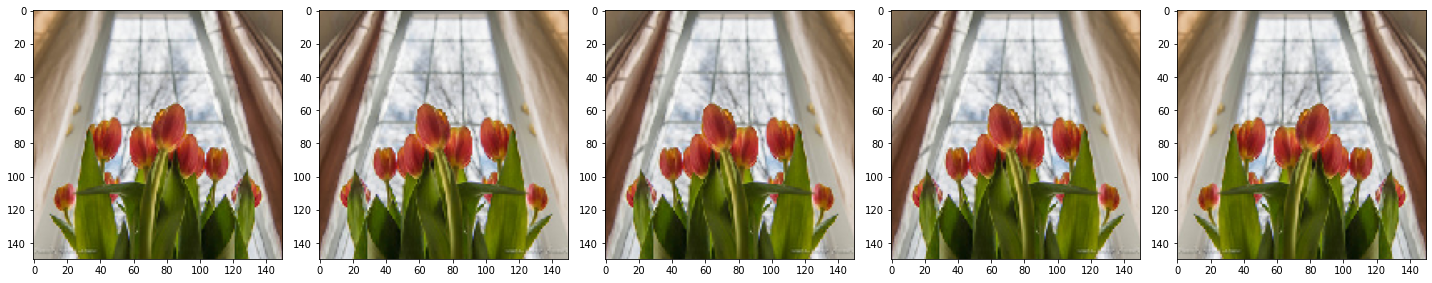

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

### Apply random rotation

In [11]:
image_gen = ImageDataGenerator(rescale=1./255,rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size= BATCH,
                                               directory= train_dir,
                                               shuffle = True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2935 images belonging to 5 classes.


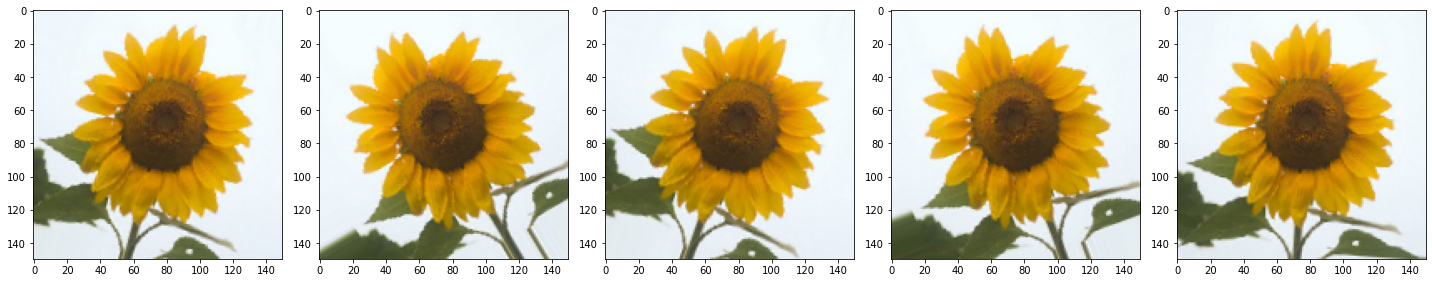

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

### Apply random zoom

In [13]:
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size = BATCH,
                                               directory = train_dir,
                                               shuffle = True,
                                               target_size = (IMG_SHAPE,IMG_SHAPE))

Found 2935 images belonging to 5 classes.


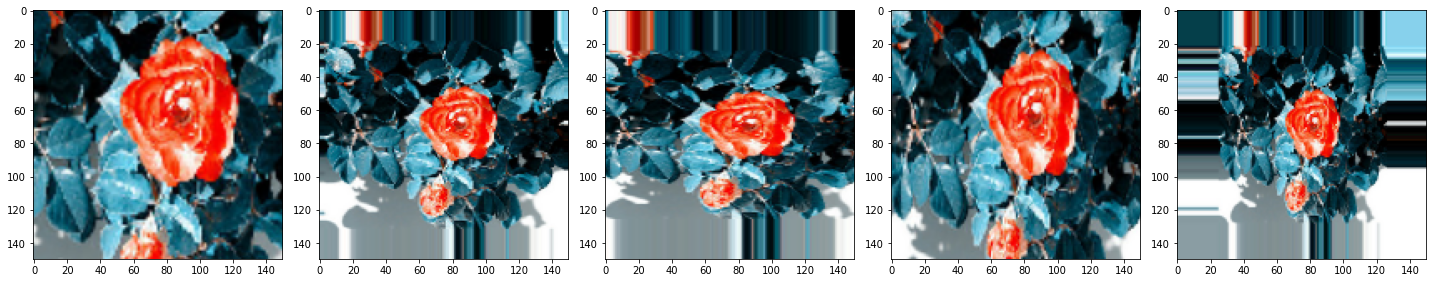

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

# Put it all together

In [15]:
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    width_shift_range = .15,
    height_shift_range = .15,
    horizontal_flip = True,
    zoom_range = 0.5
)

train_data_gen = image_gen_train.flow_from_directory(batch_size = BATCH,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'sparse')

Found 2935 images belonging to 5 classes.


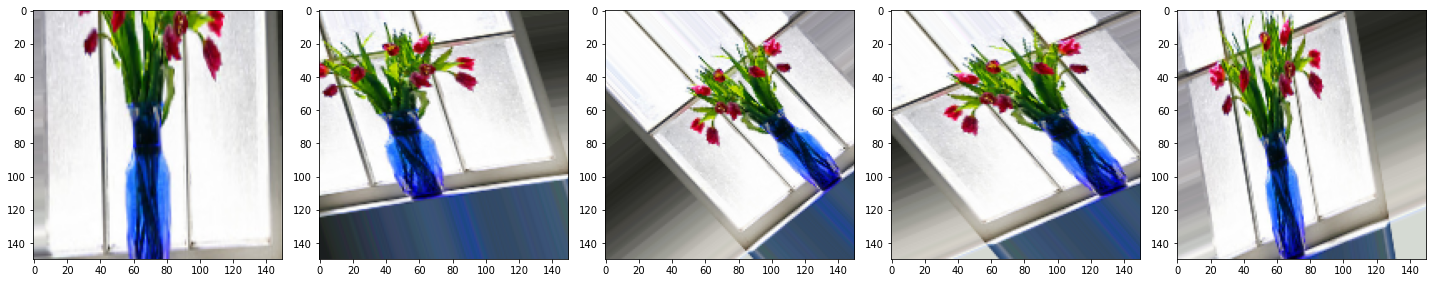

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

## Create a data generaton for the validation test

In [17]:
image_gen_val = ImageDataGenerator(rescale= 1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size = BATCH,
                                                 directory = val_dir,
                                                 shuffle = True,
                                                 target_size = (IMG_SHAPE,IMG_SHAPE),
                                                 class_mode = 'sparse')

Found 735 images belonging to 5 classes.


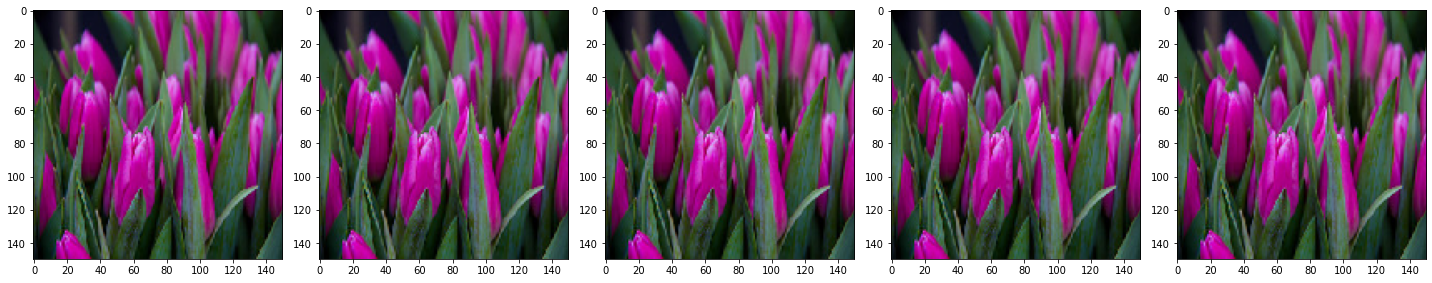

In [18]:
augmented_images = [val_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

# Create the CNN 

In [19]:
model = Sequential([
        tf.keras.layers.Conv2D(16,(3,3),  activation = 'relu',input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3) , activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3) , activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5)
      
])

# Compile The model

In [20]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Train the model

In [21]:
%%time

EPOCHS = 100

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience= 4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}--{val_loss:.2f}.h5')
]

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')
]

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH))),
    epochs=EPOCHS,
    callbacks = my_callbacks,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH)))
)

Epoch 1/100
30/30 [==============================] - 55s 744ms/step - loss: 2.0736 - accuracy: 0.2648 - val_loss: 1.3627 - val_accuracy: 0.4204
Epoch 2/100
30/30 [==============================] - 22s 737ms/step - loss: 1.2988 - accuracy: 0.4528 - val_loss: 1.1387 - val_accuracy: 0.5238
Epoch 3/100
30/30 [==============================] - 22s 739ms/step - loss: 1.1360 - accuracy: 0.5352 - val_loss: 1.0170 - val_accuracy: 0.5918
Epoch 4/100
30/30 [==============================] - 22s 738ms/step - loss: 1.0656 - accuracy: 0.5768 - val_loss: 0.9730 - val_accuracy: 0.6054
Epoch 5/100
30/30 [==============================] - 22s 750ms/step - loss: 1.0036 - accuracy: 0.6170 - val_loss: 0.9057 - val_accuracy: 0.6422
Epoch 6/100
30/30 [==============================] - 22s 736ms/step - loss: 0.9574 - accuracy: 0.6134 - val_loss: 1.0090 - val_accuracy: 0.6054
Epoch 7/100
30/30 [==============================] - 22s 734ms/step - loss: 0.9462 - accuracy: 0.6266 - val_loss: 0.8829 - val_accuracy:

# Plot training and validation graphs

Total training accuracy : 0.7294718623161316
Total validation accuracy : 0.7523809671401978


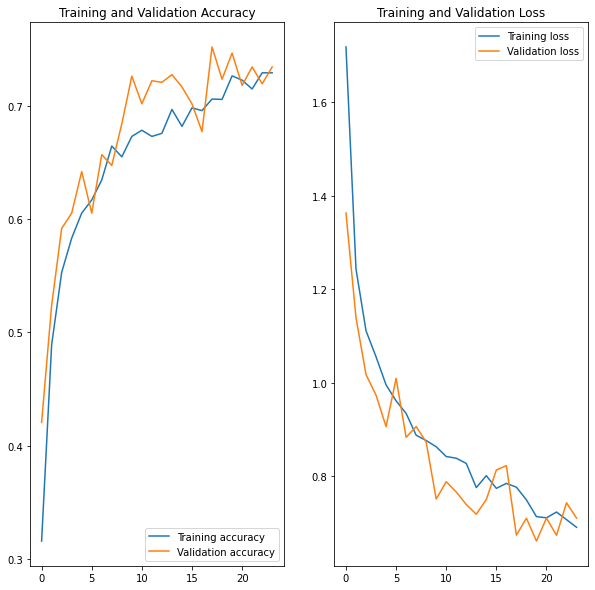

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print("Total training accuracy :",max(acc))
print("Total validation accuracy :",max(val_acc))

epochs_range = range(len(acc))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training accuracy')
plt.plot(epochs_range,val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Training loss")
plt.plot(epochs_range,val_loss,label="Validation loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()